![logo](../img/LogoLine_horizon_C3S.png)

# Exploring an ozone product available through the Climate Data Store (CDS)

In this notebook we show a practical example on how to investigate ozone products from the [CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-ozone-v1?tab=form). We will explore here the spatial and temporal ozone distribution of the total ozone columns. Total colum means here, the sum over all ozone from ground till top of the atmosphere. These are generally measured from space using earthshine backscattered radiance
observations from nadir-viewing instruments. For altitude dependent information we refer to the ozone vertical profiles. 
In a first step we will show how to retrieve one of the total ozone column dataset from the CDS. This dataset consists out of gridded monthly ozone files, which contain global distributions of ozone vertical columns on a global latitude, longitude grid. 
In a second step we perform a spatial and temporal analysis of the ozone distribution by visualizing the data. Here we present four typical use cases:
* Time series (Hovmöller diagram) of ozone: ozone distribution as a function of latitude over the years.  
* The evolution of the global ozone distribution during the course over the year 2021. 
* The evolution of the ozone hole above the Antarctic continent over the year 2021.
* The evolution of the ozone hole above the Antarctic continent over multiple years (1995-2022).  

The last step derives conclusions about the plots we made. 
From the examples in this notebook, one should have an idea on how data from the CDS can be visualized to study total ozone spatial and temporal variability. We encourage the reader to create variations on the examples here provided.  In the end, one should also be able to investigate the other ozone products in similar ways. 


## The merged total column product

In this notebook we choose to demonstrate the GTO-ECV product. GTO-ECV is a merged data product, meaning that it was build from an ensemble of bias-corrected single sensor products. The spatial resolution is 1°x1°. An interesting feature of this product is that it provides a consistent and accurate long-term total ozone dataset covering the period from July 1995 until April 2023. Note that this dataset can be extended in time on the CDS, as new data become available. Detailed information on GTO-ECV and on all other ozone products can be found in the documentation section of the CDS. An algorithm description on how those datasets were produced is given in the  Algorithm Theoretical Baseline Document ([ATBD](https://datastore.copernicus-climate.eu/documents/satellite-ozone/C3S2_312a_Lot2_ATBD_O3_latest.pdf)), a guide on the content and on how to use the data is given in the  Product User Guide and Specification document ([PUGS](https://datastore.copernicus-climate.eu/documents/satellite-ozone/C3S2_312a_Lot2_PUGS_O3_latest.pdf)). 

## Time series diagram of ozone

 

### Import the python modules

First we import the python modules that contain the high-level functions that we will use for our purposes. Most of the libraries are commonly used libraries.   

In [1]:
import numpy as np #linear algebra package
import matplotlib  #provide plotting routines
import matplotlib.pyplot as plt #provide plotting routines
import cartopy #for geospatial data analyses
import cartopy.crs as ccrs #The crs module defines Coordinate Reference Systems
import datetime as dt #library that handles the time and date. 
import xarray #library used for working with data, provides us with some easy to use data structures. Install also netCDF4 optional dependency here seperately.  
import pandas as pd #library used for working with data, we will just a few convenient functions.  
import cdsapi #python package that will allow us to make CDS dataset easily available in this notebook here. 
import zipfile #to unzip datafiles that are in zip format. 
import glob #to collect files in a directory within python

### Downloading the GTO-ECV product

The library that takes care of downloading the data from the CDS is the *cadspi* library. Which can be installed in a common way with the *pip* command. We only need to set manually the CDS API credentials, see the information on the [*How to use the CDS API*](https://cds.climate.copernicus.eu/api-how-to) webpage.

In [2]:
request=['satellite-ozone-v1',
         {'processing_level': 'level_3',
          'variable': 'atmosphere_mole_content_of_ozone',
       'vertical_aggregation': 'total_column',
          'sensor': 'merged_uv',
          'year': [f'{y:04d}' for y in range(1995,2024)],
          'month': [f'{m:02d}' for m in range(1,13)],
          'version': 'v2000'}]
datadir="./datadir" #directory where the datafiles will appear. Create this directory if not existing, the name of the path can be adapted.

The above pythonic structure can also be found on https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-ozone-v1?tab=form by choosing the desired fields and clicking on *show toolbox request*. Downloading the data from the CDS locally goes as follows:      

In [3]:
c = cdsapi.Client()
remote = c.retrieve(*request)
datazipfile=remote.download() #will download the datafiles from the CDS in a zipfile (the name of the zipfile is given by the variable datazipfile) in the current directory. 
with zipfile.ZipFile(datazipfile, "r") as zip_ref: #unzip into datadir directory
    zip_ref.extractall(datadir)
   

2024-07-02 13:44:35,888 INFO Welcome to the CDS
2024-07-02 13:44:35,889 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-ozone-v1
2024-07-02 13:44:36,140 INFO Request is queued
2024-07-02 13:44:37,186 INFO Request is running
2024-07-02 13:50:54,394 INFO Request is completed
2024-07-02 13:50:54,397 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data4/dataset-satellite-ozone-v1-da57dfc9-884e-4d94-ac22-2d38014f58aa.zip to dataset-satellite-ozone-v1-da57dfc9-884e-4d94-ac22-2d38014f58aa.zip (392.9M)
2024-07-02 13:53:44,434 INFO Download rate 2.3M/s  


### Analysis and visualisation of the data

Making the ozone dataset accessible in our notebook is done by converting the downloaded datafiles to a list of xarray objects by using: 

In [4]:
dataset=[xarray.open_dataset(f) for f in glob.glob(datadir+"/*.nc")] #construct a list of xarray objects sorted by date, these objects contains all the information that is in the monthly files. 
dataset.sort(key=lambda x: dt.datetime.strptime(x.time_coverage_start,"%Y%m%d")) #sort by increasing dates

Note that we have obtained now a data structure, named *dataset*, which is a list of monthly ozone columns over a latitude, longitude grid. Otherwise stated, the content of the requested datafiles on the CDS is now available in dataset, and we are able to do some analysis on this data. A commonly used unit for measuring ozone vertical columns is Dobson Units (DU), which is obtained by using the conversion attribute *multiplication_factor_to_convert_to_DU* :

In [5]:
for x in dataset:
    x['total_ozone_column']=x['total_ozone_column']*x['total_ozone_column'].multiplication_factor_to_convert_to_DU
  

Note that *x* represents one month. Next, we take the average along the longitude dimension.  

In [6]:
dataset_mean_long=[x.mean(dim='longitude',skipna=True) for x in dataset]

where *dataset_mean_long* is now a list of monthly ozone columns as a function of latitude. In the next step we do a technically transformation: we transform the list *dataset_mean_long* into a single xarray structure. We will see in the subsequent lines that this will provide us with an easy way of visualising the data. 

In [7]:
dataset=xarray.concat(dataset_mean_long,pd.Index([dt.datetime.strptime(x.time_coverage_start,"%Y%m%d") for x in dataset], name='date'))

*pd.Index(...)* is a method to create the extra dimension *date* in the xarray data structure. 
<br>
Next code block visualizes the dataset with a very limited number of code lines. 

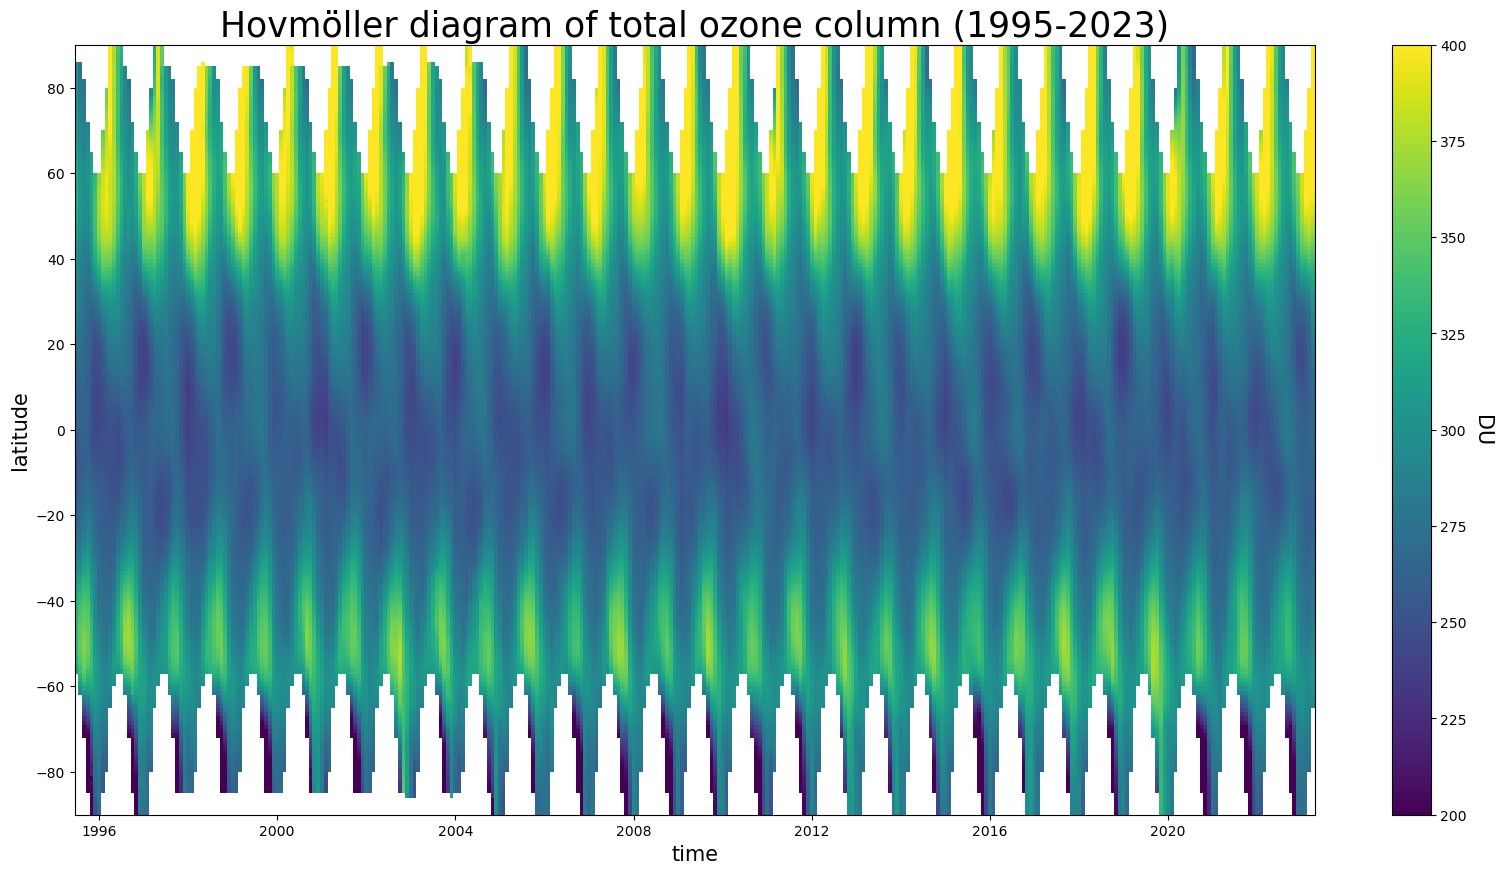

In [8]:
o3plot=dataset['total_ozone_column'].plot(x=dataset['total_ozone_column'].dims[0],y=dataset['total_ozone_column'].dims[1],cmap='viridis'\
                                          ,add_labels=False,add_colorbar=False,size=10,aspect=2.0,vmin=200,vmax=400)
# the dataset['total_ozone_column'].plot(...) line above deliver a nice figure (technically speaking this is the xarray wrapper of the function *matplotlib.pyplot.pcolormesh*) 
#However we want to set our own labels, title and add colorbar, this is done in the code below. 
ax = plt.gca() #gives the current axes instance on the current figure, this is needed to provide labels and a title on the plot. 
ax.set_xlabel("time", fontsize=15) #xlabel on the figure
ax.set_ylabel("latitude", fontsize=15) #ylabel on the figure
ax.set_title("Hovmöller diagram of total ozone column (1995-2023)", fontsize=25) #title above the figure
cbar = plt.colorbar(o3plot) #this is to attach a colorbar to the plot. 
cbar.set_label('DU', rotation=270,fontsize=15,labelpad=18) #placement of the label of the colorbar


In this plot we see how the ozone distribution varies with  latitude and time (per month). The lowest columns are found in the equatorial and tropical regions, while larger and more variable columns are observed at mid-latitude and in polar regions. This behavior results from large scale transport of air masses in the atmosphere. The signature of the ozone hole can be clearly identified each year during the austral spring season. These data can be further analysed to study the details of the variability and trends in total ozone.
The blank areas in the plot correspond to missing data (e.g. yearly polar night for measurement techniques based on solar UV radiation).

## The evolution of the global ozone distribution during the course of the year 2021



In this section we will create a series of maps which show the total ozone columns during the year 2021. We use the same dataset as in the previous section, but now limited to the year 2021. 

In [9]:
dataset2=[xarray.open_dataset(f) for f in glob.glob(datadir+"/2021*.nc")]
dataset2.sort(key=lambda x: dt.datetime.strptime(x.time_coverage_start,"%Y%m%d"))

We create in the code block below 12 world maps. The gridded (in latitude, longitude) monthly datafiles, now contained in *dataset2*, are directly usable. Therefore the next code lines are dealing with the construction of the plots. Note that we use here a different way to create a plot then in the previous section, because this approach is more suitable when creating plots that contains multiple subplots.    

/opt/homebrew/Caskroom/miniforge/base/envs/CDS/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


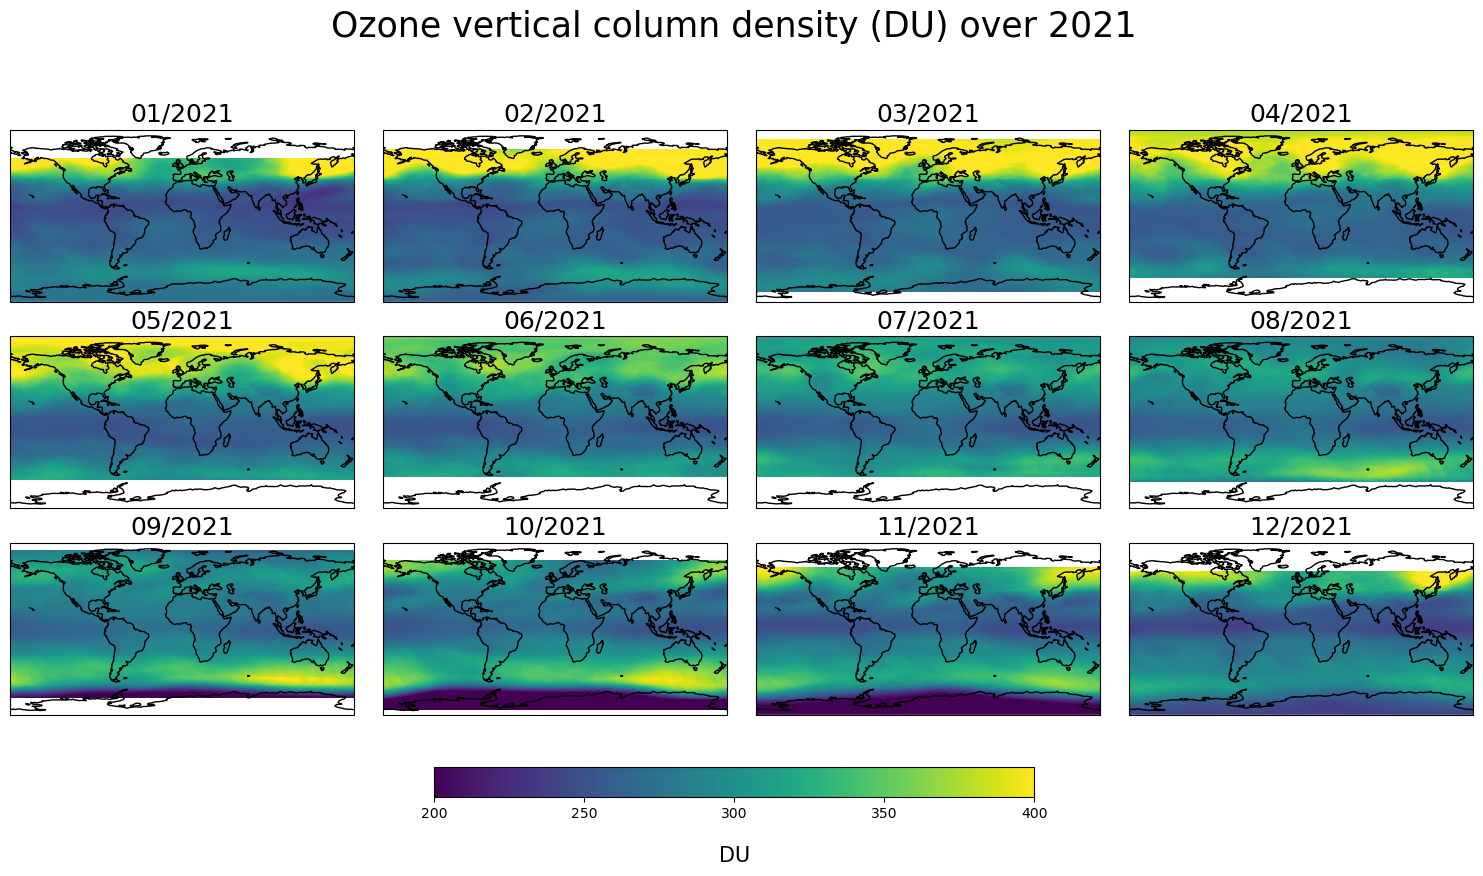

In [10]:
proj=ccrs.PlateCarree() #choose projection
latlon_bounds=[-180, 180, -90, 90] #latitude, longitude boundaries
figure, axs = plt.subplots(nrows=3,ncols=4,figsize=(15,15),subplot_kw={'projection': proj}); #prepare the 12 maps for the different subplots. 
axs=axs.flatten() #needed to be able to loop in the next line over the axes.
for x in axs:
    x.set_extent(latlon_bounds, crs=ccrs.PlateCarree()) #method to set the boundaries               
figure.suptitle("Ozone vertical column density (DU) over 2021",fontsize=25) #main title
for i,data in enumerate(dataset2): #loop over the monthly total ozone column data
    o3=data['total_ozone_column'].to_numpy()*data['total_ozone_column'].multiplication_factor_to_convert_to_DU #conversion to Dobson units. 
    #converting to numpy datastructure, this is needed when feeding the plotting routine pcolormesh further. 
    lat=data['latitude'].to_numpy() #converting to numpy datastructure, this is needed when feeding the plotting routine pcolormesh further. 
    long=data['longitude'].to_numpy() #converting to numpy datastructure, this is needed when feeding the plotting routine pcolormesh further. 
    dat=dt.datetime.strptime(data.time_coverage_start,"%Y%m%d") #extracting the date
    datstr=dt.datetime.strftime(dat,"%m/%Y") #month/year structure
    axs[i].coastlines() #adding lines around the coasts. 
    axs[i].set_title('{}'.format(datstr),fontsize=18) # update title of each subplot with attribute time_coverage_start, formatted as month/year. 
    cs=axs[i].pcolormesh(long,lat,o3,shading='auto',cmap='viridis',transform=ccrs.PlateCarree(),vmin=200,vmax=400) #plotting routine to colour the map according to 
    #the ozone distributions.
figure.subplots_adjust(bottom=0.51, top=0.9, left=0.01, right=1.0,wspace=0.02, hspace=0.2) #positioning of the different subplots. 
cbar_ax = figure.add_axes([0.3, 0.455, 0.4, 0.02]) #positioning of the colorbar. 
cbar=figure.colorbar(cs,cax=cbar_ax,ticks=np.arange(100,550,50),orientation='horizontal') #add a colorbar
cbar.set_label('DU', rotation=0,fontsize=15,labelpad=18) #label for the colorbar
plt.show()

These plots illustrate the seasonal evolution of the global ozone distribution. The variability of stratospheric ozone in the Arctic and at mid-latitudes is particularly important in spring when returning sunlight (after the polar night) alters stratospheric temperatures via shortwave heating, thus modifying atmospheric dynamics. During the mid-latitude summer season and in the tropics, ozone columns are smaller and show less variability. The Southern hemisphere is characterised by the ozone hole, which develops each year in early spring (from September to November). The signature of this ozone hole is captured in the data noting that at high southern latitudes data remain unavailable (the blank regions corresponds to the polar night when no measurements can be performed).


## The evolution of the ozone hole above Antarctica

A very interesting figure can be made by just changing the projection of the previous plot. Now we look in a polar projection over the South Pole to investigate
the ozone hole over Antartica during austral spring. 

/opt/homebrew/Caskroom/miniforge/base/envs/CDS/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


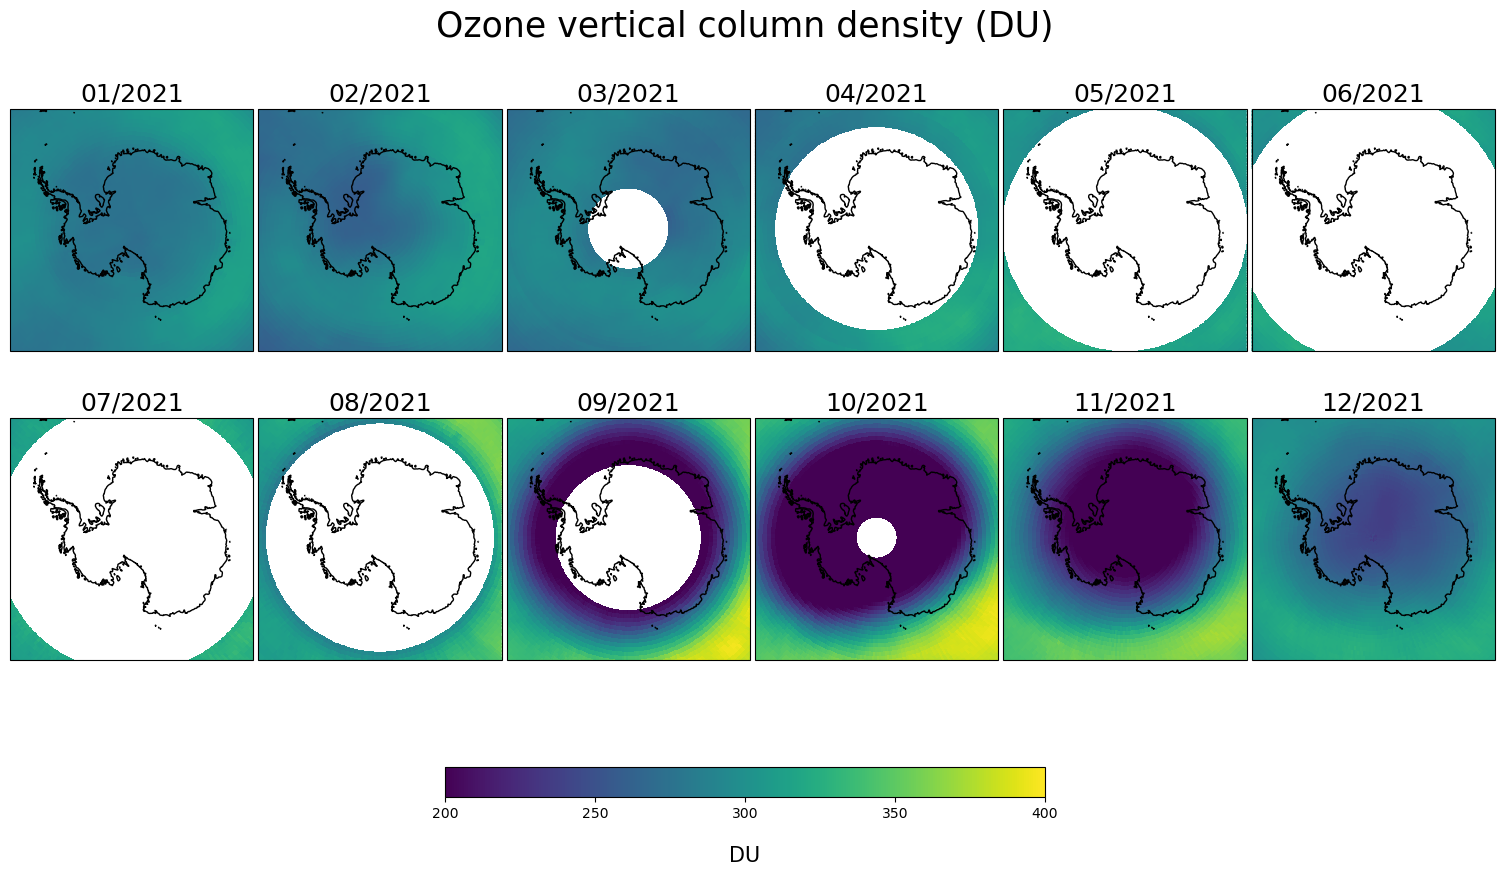

In [11]:
proj=ccrs.SouthPolarStereo() #choose projection
latlon_bounds=[-180, 180, -90, -60] #latitude, longitude boundaries
figure, axs = plt.subplots(nrows=2,ncols=6,figsize=(15,15),subplot_kw={'projection': proj});
axs=axs.flatten()
for x in axs:
    x.set_extent(latlon_bounds, crs=ccrs.PlateCarree())                
figure.suptitle("Ozone vertical column density (DU)",fontsize=25)
for i,data in enumerate(dataset2): 
    o3=data['total_ozone_column'].to_numpy()*data['total_ozone_column'].multiplication_factor_to_convert_to_DU
    lat=data['latitude'].to_numpy()
    long=data['longitude'].to_numpy()
    dat=dt.datetime.strptime(data.time_coverage_start,"%Y%m%d")
    datstr=dt.datetime.strftime(dat,"%m/%Y")
    axs[i].coastlines()
    axs[i].set_title('{}'.format(datstr),fontsize=18)
    cs=axs[i].pcolormesh(long,lat,o3,shading='auto',cmap='viridis',transform=ccrs.PlateCarree(),vmin=200,vmax=400)
figure.subplots_adjust(bottom=0.51, top=0.95, left=0.01, right=1.0,wspace=0.02, hspace=-0.12)
cbar_ax = figure.add_axes([0.3, 0.455, 0.4, 0.02])
cbar=figure.colorbar(cs,cax=cbar_ax,ticks=np.arange(100,550,50),orientation='horizontal')
cbar.set_label('DU', rotation=0,fontsize=15,labelpad=18)
plt.show()

This plot shows the ozone hole in the Southern hemisphere seen from a polar projection. The ozone hole (dark region) develops each year in early spring (from September to November). As mentioned already, the blank regions are due to the polar night. 

## Time series of the ozone hole over the years in the polar projection during October

In line with the two previous use cases, we can also show the evolution of the ozone hole over the years 1995 to 2022 during the month October. 

In [12]:
dataset3=[xarray.open_dataset(f) for f in glob.glob(datadir+"/????10*.nc")] #extract the files from each year of the month October and create xarray objects.
dataset3.sort(key=lambda x: dt.datetime.strptime(x.time_coverage_start,"%Y%m%d"))

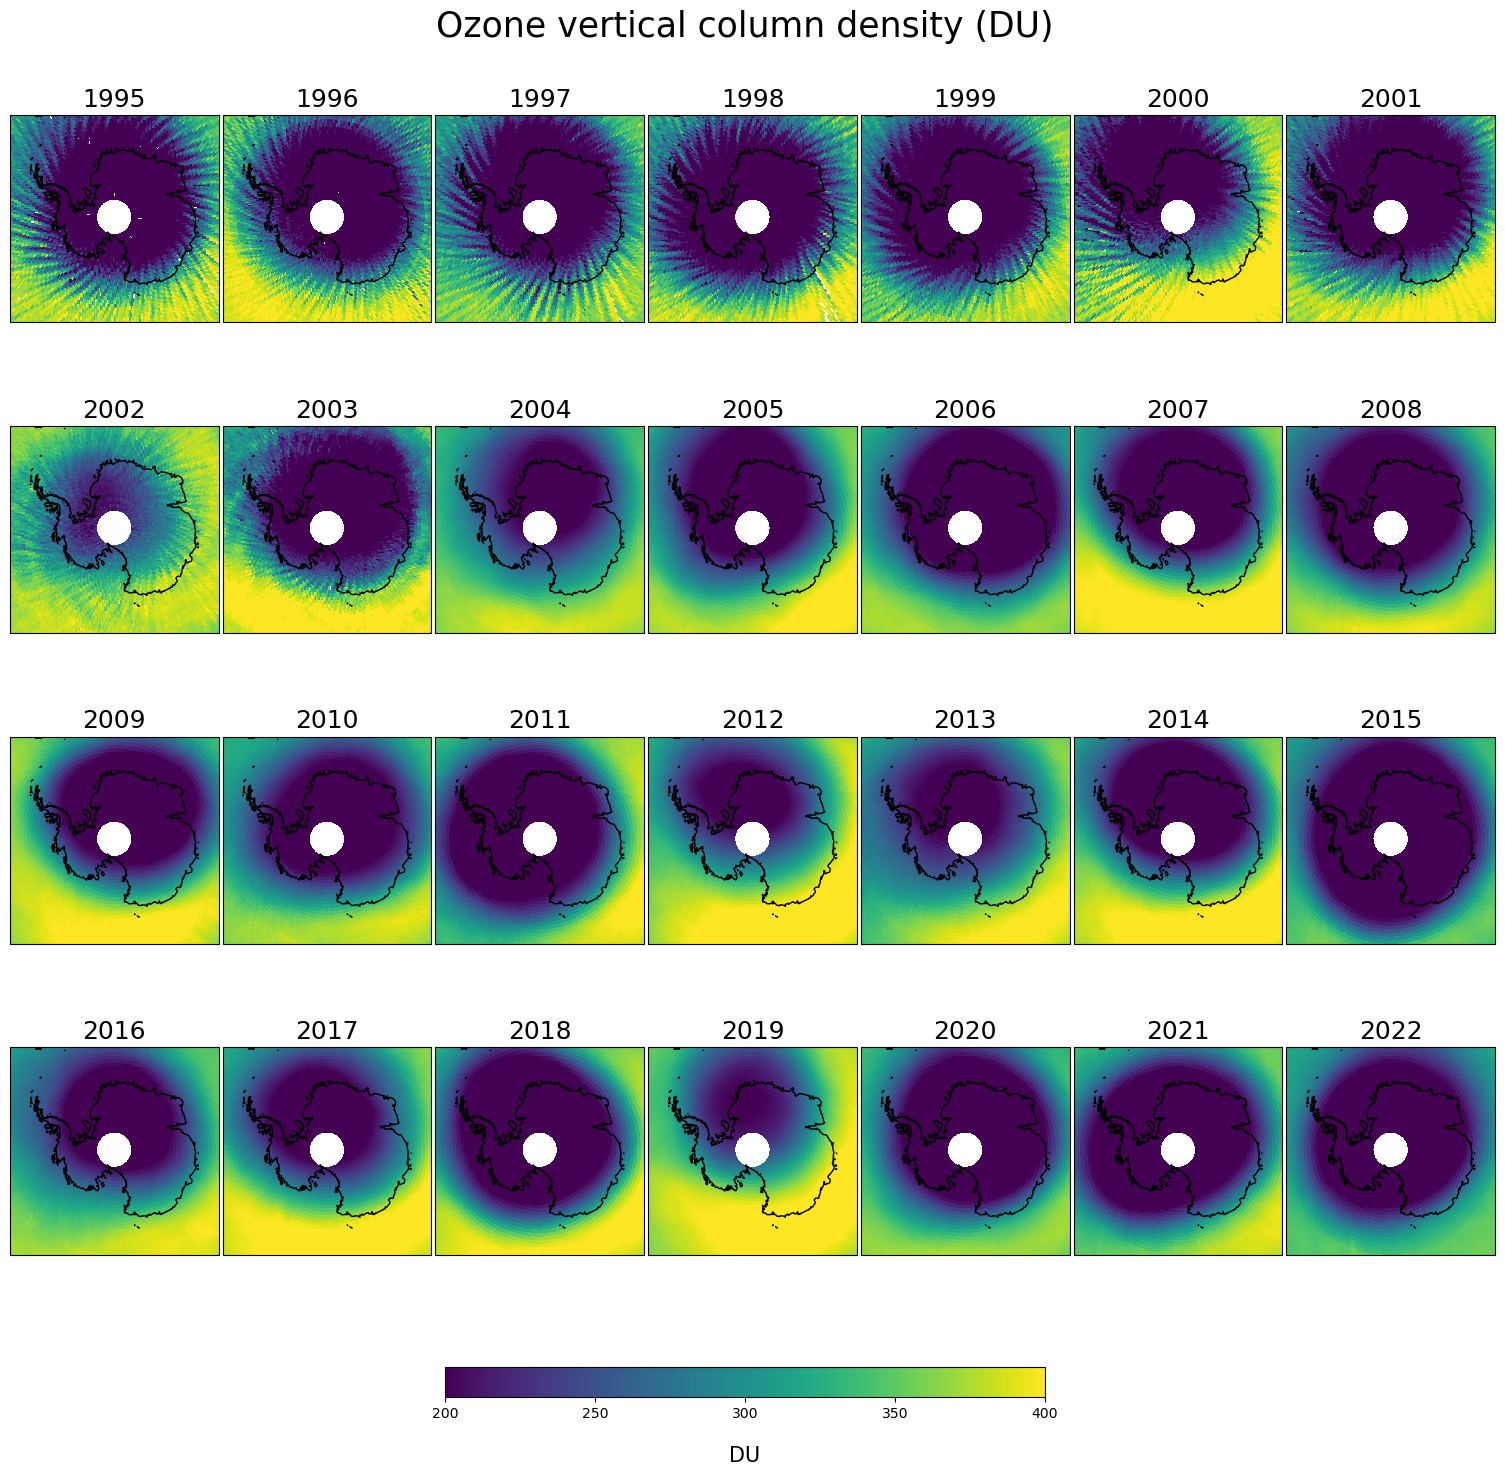

In [13]:
proj=ccrs.SouthPolarStereo() #choose projection
latlon_bounds=[-180, 180, -90, -60] #latitude, longitude boundaries
figure, axs = plt.subplots(nrows=4,ncols=7,figsize=(15,15),subplot_kw={'projection': proj});
axs=axs.flatten()
for x in axs:
    x.set_extent(latlon_bounds, crs=ccrs.PlateCarree())                
figure.suptitle("Ozone vertical column density (DU)",fontsize=25)
for i,data in enumerate(dataset3): 
    o3=data['total_ozone_column'].to_numpy()*data['total_ozone_column'].multiplication_factor_to_convert_to_DU
    lat=data['latitude'].to_numpy()
    long=data['longitude'].to_numpy()
    dat=dt.datetime.strptime(data.time_coverage_start,"%Y%m%d")
    datstr=dt.datetime.strftime(dat,"%Y")
    axs[i].coastlines()
    axs[i].set_title('{}'.format(datstr),fontsize=18)
    cs=axs[i].pcolormesh(long,lat,o3,shading='auto',cmap='viridis',transform=ccrs.PlateCarree(),vmin=200,vmax=400)
figure.subplots_adjust(top=0.95, left=0.01, right=1.0,wspace=0.02, hspace=-0.05)
cbar_ax = figure.add_axes([0.3, 0.055, 0.4, 0.02])
cbar=figure.colorbar(cs,cax=cbar_ax,ticks=np.arange(100,550,50),orientation='horizontal')
cbar.set_label('DU', rotation=0,fontsize=15,labelpad=18)
plt.show()


This plot shows the ozone hole in the southern hemisphere seen from a polar projection, from 1995 to 2022 in October. Up to 2002 the GTO-ECV data record consists out of GOME/ERS-2 data only. This sensor had a relatively sparse spatial sampling compared to
the sensors included in GTO-ECV in the later period. Moreover, the size of the GOME ground-pixels was much larger. Global coverage was achieved only after 3 days, which can have a significant impact on monthly mean values, in particular in months characterized by considerable changes in total ozone columns, e.g. boreal or austral spring. The result is the stripy structure in the ozone distribution in the nineties, which vanished with the ingestion of the additional satellite sensors, e.g. OMI, with better sampling.